# MIRI LRS Slit Spectroscopy: Pathloss correction issues and workaround

### Author, Date

Sarah Kendrew, ESA and STScI MIRI Branch, skendrew@stsci.edu</br>
August 2023

**Use case:** Demonstration of the path loss correction issue for MIRI LRS slit observations.<br>
**Data:** Multiple<br>
**Tools:** jwst, matplotlib, astropy.<br>
**Cross-intrument:** MIRI.<br>


## Introduction

The Path Loss correction step is part of the JWST Spec2Pipeline ("stage 2"), and applies a correction to MIRI LRS slit data to account for the flux lost due to the finite size of the slit. The slit measures just $\sim$ 0.5 arcsec in width, which is small compared to the size of the PSF in the LRS wavelength range; even when the target perfectly placed at the slit centre, some flux is lost. 

The JWST calibration pipeline (to build 9.3) uses the target coordinates to identify the location of the target in the slit, and computes the required correction factors as a function of wavelength. However the target RA, Dec in the FITS headers of the data are inherited from APT, and for high proper motion targets or coordinates with a larger amount of uncertainty, they may not be accurate for the day & time of the actual observation. 

For a small number of observations this causes the path loss step to apply wildly incorrect factors to one or both nodded exposures. As a results, the final products give corrupted results. An example is shown below (note this image is rotated by 90 degrees for better visibility; LRS spectra are dispersed vertically). 

![Corrupted path loss example](lrs_pathloss_example_bad.png)

## Workaround

The easiest workaround for the majority of corrupted data due to path loss issues is to apply a correction to the TARG_RA and TARG_DEC keywords of the original file, to ensure that the computation of the path loss correction is correct. A function to correct the coordinates can be found in [this notebook](https://github.com/spacetelescope/jwst-caveat-examples/blob/main/general_issues/general_targ_ra_dec.ipynb). 

In the above notebook the function is applied to the ``uncal`` data file, however it can also be applied to the ``rate`` file, as all steps of the Detector1Pipeline are coordinate-agnostic. 

We demonstrate below the workflow to apply the correcting function to the data, and re-running the data through the Stage 2 and 3 pipelines. **Note: as the affected datasets so far are all still under exclusive access (such as the example shown above), we demonstrate the method on publicly available data that does not show the problem.** 

## Data

We use for this demo the data from program 1538, which is an absolute flux calibration program. You can download the data from [this Box folder](https://stsci.box.com/s/o7dyl2qr7azznjahcp1qlx2ekvyxygrd) and we recommend that you put the files in a ``data/`` subfolder of this notebook (or update the directory settings in the notebook). We include in the downloads the default association files from MAST, which we can reuse for this workaround. 

Reminder: these data are not actually affected by the coordinate problem that causes the path loss step to bork. 


## Future prospect

A fix for the TARG_RA and TARG_DEC coordinates issue is included in JWST pipeline Build 9.3 (version 1.11) which will reprocess all archival data to correct the problem. This reprocessing will begin around August 24th and will take around 4 weeks to complete. 

We expect this will correct most or all of the problems with the path loss step for MIRI LRS. If your data still show problems, **please contact the Helpdesk** so we can investigate further and provide support. 

In [ ]:
import os
os.environ['CRDS_CONTEXT'] = 'jwst_1089.pmap'

In [14]:
%matplotlib inline
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as fits
import astropy.units as u

from jwst.pipeline import Spec2Pipeline, Spec3Pipeline
from jwst import datamodels
from jwst.extract_1d import Extract1dStep

import jwst
print('Using JWST calibration pipeline version {0}'.format(jwst.__version__))

Using JWST calibration pipeline version 1.10.2


### Identify the nod 1 and 2 exposures

In [3]:
data_dir = 'data/'
obs_files = [data_dir + of for of in ['jw01538021001_05101_00001_mirimage_rate.fits', 'jw01538021001_05101_00002_mirimage_rate.fits']]

print(obs_files)


['data/jw01538021001_05101_00001_mirimage_rate.fits', 'data/jw01538021001_05101_00002_mirimage_rate.fits']


### RA & Dec correction function 

This is simply copied from [this notebook](https://github.com/spacetelescope/jwst-caveat-examples/blob/main/general_issues/general_targ_ra_dec.ipynb) written by Jeff Valenti (STScI). The function updates the RA, Dec parameters in the FITS header **in place**, i.e. no new file is created. 

In [4]:
from astropy.time import Time
from astropy.units import arcsec, deg, pc, yr
from astropy.io import fits
from math import cos, pi

def fix_radec(path, distance=1000*pc):
    '''Fix TARG_RA and TARG_DEC in primary FITS header.'''
    with fits.open(path, 'update') as hdulist:
        header = hdulist['primary'].header
        prop_ra = header['prop_ra'] # deg
        prop_dec = header['prop_dec'] # deg
        mu_epoch = Time(header['mu_epoch'])
        mu_ra = header['mu_ra'] # arcsec / yr
        mu_dec = header['mu_dec'] # arcsec / yr
        expmid = Time(header['expmid'], format='mjd')
        dtime = Time(expmid, format='mjd') - Time(mu_epoch)
        dyear = dtime.to(yr).value
        new_targ_ra = prop_ra + dyear * mu_ra / 3600 / cos(pi * prop_dec / 180)
        new_targ_dec = prop_dec + dyear * mu_dec / 3600
        
        old_targ_ra = header['targ_ra']
        old_targ_dec = header['targ_dec']
        print(f'old: targ_ra={old_targ_ra:.6f}, targ_dec={old_targ_dec:.6f}')
        header['targ_ra'] = new_targ_ra
        header['targ_dec'] = new_targ_dec
        print(f'new: targ_ra={new_targ_ra:.6f}, targ_dec={new_targ_dec:.6f}')

In [5]:
for of in obs_files:
    fix_radec(of)

old: targ_ra=247.890862, targ_dec=30.146133
new: targ_ra=247.890820, targ_dec=30.145979
old: targ_ra=247.890862, targ_dec=30.146133
new: targ_ra=247.890820, targ_dec=30.145979


In [11]:
ra_old1 = 247.890862 * u.deg
ra_new1 = 247.890820 * u.deg
dra1 = (ra_new1 - ra_old1).to(u.arcsec)
print(dra1)

dec_old1 = 30.146133 * u.deg
dec_new1 = 30.145979 * u.deg
ddec1 = (dec_new1 - dec_old1).to(u.arcsec)
print(ddec1)


-0.1512000000275293 arcsec
-0.5543999999943594 arcsec


### Re-run the Spec2Pipeline

We use as input the association files that we downloaded from MAST for thie observation. We can create associations manually, but as the filenames have not been changes, the existing associations should be fine. We will skip the resample and extraction steps here, as we don't need those products for our purposes here. 

In [12]:
asn_nod1_file = 'data/jw01538-o021_20230720t185414_spec2_00001_asn.json'
asn_nod2_file = 'data/jw01538-o021_20230720t185414_spec2_00002_asn.json'
asn_files = [asn_nod1_file, asn_nod2_file]

In [15]:
out_dir = 'data/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [17]:
sp2s = []
for af in asn_files:
    sp2_out = Spec2Pipeline.call(af, save_results=True, output_dir=out_dir, 
                                 steps={'assign_wcs': {'save_results': True}, 'resample_spec': {'skip': True}, 
                                        'extract_1d': {'skip': True}})
    sp2s.append(sp2_out)
print(sp2s)

2023-08-13 18:46:19,739 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_pars-spec2pipeline_0003.asdf
2023-08-13 18:46:19,756 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-08-13 18:46:19,757 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-08-13 18:46:19,758 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-08-13 18:46:19,758 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-08-13 18:46:19,759 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-08-13 18:46:19,760 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-08-13 18:46:19,762 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-08-13 18:46:19,763 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created

2023-08-13 18:46:20,057 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01538021001_05101_00002_mirimage_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-08-13 18:46:20,062 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-08-13 18:46:20,062 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-08-13 18:46:20,062 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-08-13 18:46:20,062 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-08-13 18:46:20,063 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2023-08-13 18

2023-08-13 18:46:21,265 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from data/jw01538021001_05101_00001_mirimage_rate.fits
2023-08-13 18:46:21,465 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /Users/skendrew/anaconda3/envs/jwst1.10.2/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:364: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
2023-08-13 18:46:21,466 - stpipe.Spec2Pipeline.bkg_subtract - WARNING -   warnings.warn(
2023-08-13 18:46:21,466 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - 
2023-08-13 18:46:21,623 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-08-13 18:46:21,685 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from jw01538021001_05101_00002_mirimage_assign_wcs.fits>,).
2023-08-13 18:46:21,686 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks

2023-08-13 18:46:22,844 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': 'data', 'save_intermediate_results': False, 'ignore_region_min': None, 'ignore_region_max': None}
2023-08-13 18:46:22,845 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.
2023-08-13 18:46:22,847 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe done
2023-08-13 18:46:22,994 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from data/jw01538021001_05101_00002_mirimage_cal.fits>,).
2023-08-13 18:46:22,995 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': No

2023-08-13 18:46:23,897 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01538021001_05101_00001_mirimage_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-08-13 18:46:23,901 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-08-13 18:46:23,901 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-08-13 18:46:23,901 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-08-13 18:46:23,901 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-08-13 18:46:23,902 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2023-08-13 18

2023-08-13 18:46:25,115 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from data/jw01538021001_05101_00002_mirimage_rate.fits
2023-08-13 18:46:25,313 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /Users/skendrew/anaconda3/envs/jwst1.10.2/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:364: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
2023-08-13 18:46:25,314 - stpipe.Spec2Pipeline.bkg_subtract - WARNING -   warnings.warn(
2023-08-13 18:46:25,314 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - 
2023-08-13 18:46:25,464 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-08-13 18:46:25,536 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from jw01538021001_05101_00001_mirimage_assign_wcs.fits>,).
2023-08-13 18:46:25,537 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks

2023-08-13 18:46:26,770 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': 'data', 'save_intermediate_results': False, 'ignore_region_min': None, 'ignore_region_max': None}
2023-08-13 18:46:26,771 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.
2023-08-13 18:46:26,773 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe done
2023-08-13 18:46:26,930 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from data/jw01538021001_05101_00001_mirimage_cal.fits>,).
2023-08-13 18:46:26,931 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': No

[[<ImageModel(1024, 1032) from jw01538021001_05101_00002_mirimage_cal.fits>], [<ImageModel(1024, 1032) from jw01538021001_05101_00001_mirimage_cal.fits>]]


### Re-run the Spec3Pipeline

We proceed with the Spec3Pipeline, which will resample & combine the 2 calibrated nod exposures and give us our final product. We can again use the default pipeline association file, which was downloaded from MAST

In [19]:
asn_file_stage3 = 'data/jw01538-o021_20230720t185414_spec3_00001_asn.json'

sp3_out = Spec3Pipeline.call(asn_file_stage3, save_results=True, output_dir=out_dir)

2023-08-13 18:55:01,901 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_pars-spec3pipeline_0001.asdf
2023-08-13 18:55:01,914 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-08-13 18:55:01,915 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-08-13 18:55:01,916 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-08-13 18:55:01,917 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-08-13 18:55:01,919 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-08-13 18:55:01,920 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-08-13 18:55:01,921 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2023-08-13 18:55:01,923 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2023-08-13 18:

2023-08-13 18:55:02,891 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'data', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}
2023-08-13 18:55:02,897 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing outlier detection on 2 inputs
2023-08-13 18:55:03,070 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter kernal: square
2023-08-13 18:55:03,070 - stpipe.Spec3Pipeline.outlier_detection - INFO - D

2023-08-13 18:55:10,476 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


In [20]:
new_s2d = 'data/jw01538-o021_t002_miri_p750l_s2d.fits'
old_s2d = 'data/jw01538-o021_t002_miri_p750l_s2d_default.fits'

new = datamodels.open(new_s2d)
old = datamodels.open(old_s2d)

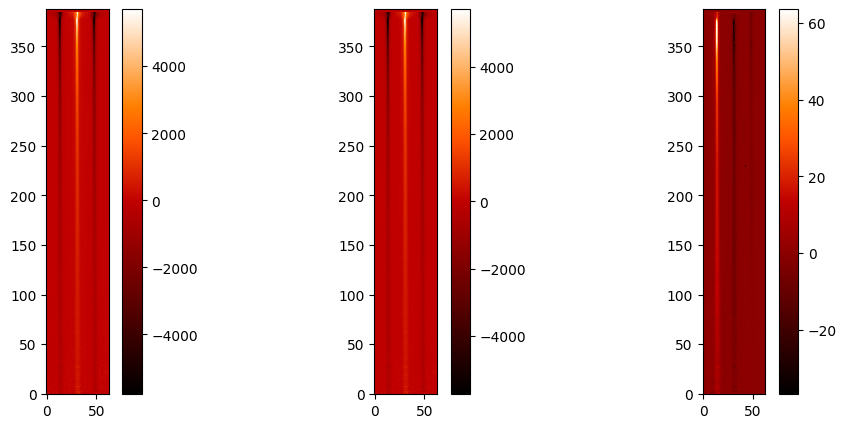

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=[12,5])

im1 = ax[0].imshow(old.data, origin='lower', cmap='gist_heat')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(new.data, origin='lower', cmap='gist_heat')
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].imshow(new.data-old.data, origin='lower', cmap='gist_heat')
fig.colorbar(im3, ax=ax[2])


2023-08-13 19:04:33,254 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_45415/1767914469.py:9: RuntimeWarning: invalid value encountered in divide
2023-08-13 19:04:33,255 - stpipe - WARNING -   ax2.plot(newspec.spec[0].spec_table['WAVELENGTH'], newspec.spec[0].spec_table['FLUX']/oldspec.spec[0].spec_table['FLUX'], 'g-', label='new/old ratio')
2023-08-13 19:04:33,255 - stpipe - WARNING - 
2023-08-13 19:04:33,257 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_45415/1767914469.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-08-13 19:04:33,258 - stpipe - WARNING -   fig2.show()
2023-08-13 19:04:33,258 - stpipe - WARNING - 


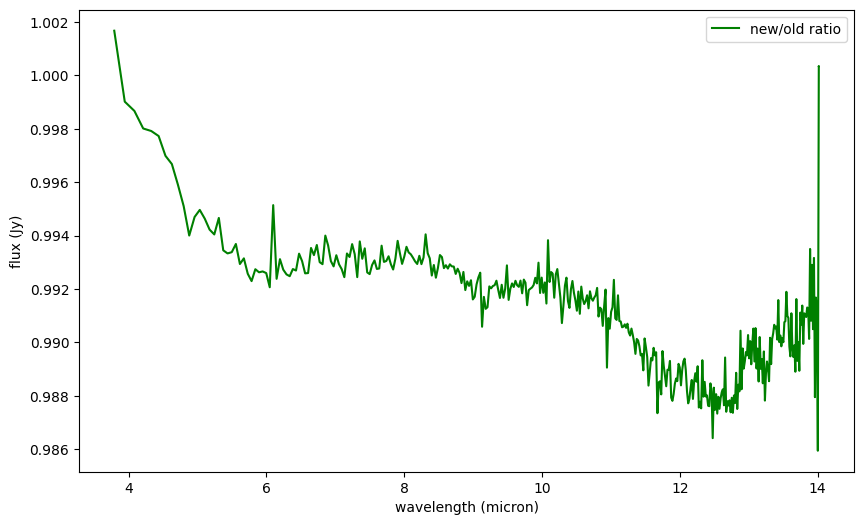

In [24]:
new_x1d = 'data/jw01538-o021_t002_miri_p750l_x1d.fits'
old_x1d = 'data/jw01538-o021_t002_miri_p750l_x1d_default.fits'

newspec = datamodels.open(new_x1d)
oldspec = datamodels.open(old_x1d)

fig2, ax2 = plt.subplots(figsize=[10,6])
#ax2.plot(oldspec.spec[0].spec_table['WAVELENGTH'], oldspec.spec[0].spec_table['FLUX'], 'b-', label='pipeline deafult')
ax2.plot(newspec.spec[0].spec_table['WAVELENGTH'], newspec.spec[0].spec_table['FLUX']/oldspec.spec[0].spec_table['FLUX'], 'g-', label='new/old ratio')
ax2.set_xlabel('wavelength (micron)')
ax2.set_ylabel('flux (Jy)')
ax2.legend()
fig2.show()


As we can see, even for datasets that appear to be fine when processed usingthe default pipeline there are subtle differences when the coordinates are updated in the header prior to calibrations. In this case the difference is of order 1-2%. 

As from September 2023 the coordinates will be accurately included in the FITS header; until then, ths RA, Dec correction function shown here can help resolve coordinate-related issues, which for MIRI LRS **slit** observations manifest predominantly in the ``path_loss`` step. 

If you have any further questions, please contact us via the Helpdesk. 

END

-- S. Kendrew, Aug 2023